In [1]:
import cv2
import numpy as np
import math
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt # 用于在notebook中显示图像

导入所需的库

In [2]:
POSE_MODEL_PATH = 'best.pt'  # <--- POSE模型
DETECTION_MODEL_PATH = 'object.pt'  # <--- 对象检测模型
IMAGE_PATH = 'F:\darts_reco\darts_yolo_dataset_multiobj/val\images\DSC_0051.JPG'  # <--- 测试图片路径

POSE_CONFIDENCE_THRESHOLD = 0.5  # Pose 模型检测置信度阈值
DETECTION_CONFIDENCE_THRESHOLD = 0.4  # Detection 模型检测置信度阈值 (飞镖)

DARTBOARD_CLASS_NAME = 'dartboard'  # Pose模型中飞镖盘的类别名称
DART_CLASS_NAME = 'dart'  # Detection模型中飞镖的类别名称
EXPECTED_KEYPOINTS = 4  # 期望的飞镖盘关键点数量

# --- 标准飞镖盘定义 (归一化，中心为 0,0) ---
CANONICAL_CENTER_X = 0.0
CANONICAL_CENTER_Y = 0.0
CANONICAL_RADIUS_OUTER_DOUBLE = 1.0

R_MM = {'double_outer': 170.0, 'double_inner': 162.0, 'triple_outer': 107.0,
        'triple_inner': 99.0, 'bull_outer': 15.9, 'bull_inner': 6.35}
R_NORM = {name: radius / R_MM['double_outer'] for name, radius in R_MM.items()}
print("归一化半径:", R_NORM)

SEGMENT_VALUES = [20, 1, 18, 4, 13, 6, 10, 15, 2, 17, 3, 19, 7, 16, 8, 11, 14, 9, 12, 5]
SEGMENT_ANGLE = 360.0 / len(SEGMENT_VALUES)

angle_45_rad = math.radians(45)
cos_45 = math.cos(angle_45_rad)
sin_45 = math.sin(angle_45_rad)
INITIAL_TARGET_POINTS_NORMALIZED = np.array([
    [-cos_45, sin_45],  # TL (初始假设在 135 度)
    [cos_45, sin_45],  # TR (初始假设在 45 度)
    [cos_45, -sin_45],  # BR (初始假设在 -45 / 315 度)
    [-cos_45, -sin_45]  # BL (初始假设在 -135 / 225 度)
], dtype=np.float32)
print("初始目标归一化坐标点 (TL, TR, BR, BL):\n", INITIAL_TARGET_POINTS_NORMALIZED)

rotation_angle_deg = -36.0
rotation_angle_rad = math.radians(rotation_angle_deg)
cos_rot = math.cos(rotation_angle_rad)
sin_rot = math.sin(rotation_angle_rad)

TARGET_POINTS_NORMALIZED_ROTATED = np.zeros_like(INITIAL_TARGET_POINTS_NORMALIZED)
for i, point in enumerate(INITIAL_TARGET_POINTS_NORMALIZED):
    x, y = point
    x_new = x * cos_rot - y * sin_rot
    y_new = x * sin_rot + y * cos_rot
    TARGET_POINTS_NORMALIZED_ROTATED[i] = [x_new, y_new]
print(f"旋转 {rotation_angle_deg} 度后的最终目标归一化坐标点:\n", TARGET_POINTS_NORMALIZED_ROTATED)

VIS_WIDTH = 500
VIS_HEIGHT = 500
VIS_CENTER_X = VIS_WIDTH / 2
VIS_CENTER_Y = VIS_HEIGHT / 2
VIS_SCALE_FACTOR = min(VIS_WIDTH, VIS_HEIGHT) / 2 * 0.9

归一化半径: {'double_outer': 1.0, 'double_inner': 0.9529411764705882, 'triple_outer': 0.6294117647058823, 'triple_inner': 0.5823529411764706, 'bull_outer': 0.09352941176470589, 'bull_inner': 0.03735294117647059}
初始目标归一化坐标点 (TL, TR, BR, BL):
 [[   -0.70711     0.70711]
 [    0.70711     0.70711]
 [    0.70711    -0.70711]
 [   -0.70711    -0.70711]]
旋转 -36.0 度后的最终目标归一化坐标点:
 [[   -0.15643     0.98769]
 [    0.98769     0.15643]
 [    0.15643    -0.98769]
 [   -0.98769    -0.15643]]


配置相关内容

In [3]:
def find_intersection(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0: return None
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denominator
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denominator
    if 0 <= t <= 1 and 0 <= u <= 1:
        return np.array([x1 + t * (x2 - x1), y1 + t * (y2 - y1)], dtype=np.float32)
    else:
        return None

计算交点、排序点的方法

In [4]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

排序点的方法

In [5]:
def calculate_score_normalized(tx, ty, r_norm, segment_values, segment_angle):
    radius_norm = math.sqrt(tx ** 2 + ty ** 2)
    if radius_norm > r_norm['double_outer']: return 0, "Outside Board"
    if radius_norm <= r_norm['bull_inner']: return 50, "Bullseye"
    if radius_norm <= r_norm['bull_outer']: return 25, "Outer Bull"

    angle_rad = math.atan2(ty, tx)
    angle_deg_atan2 = math.degrees(angle_rad)
    clockwise_angle = (90 - angle_deg_atan2 + 360) % 360
    # 使用原始 clockwise_angle 计算分区
    adjusted_clockwise = (clockwise_angle + (segment_angle / 2) + 360) % 360
    segment_index = int(adjusted_clockwise // segment_angle) % len(segment_values)
    base_score = segment_values[segment_index]

    multiplier = 1
    zone = f"Single {base_score}"
    if r_norm['double_inner'] <= radius_norm <= r_norm['double_outer']:
        multiplier = 2; zone = f"Double {base_score}"
    elif r_norm['triple_inner'] <= radius_norm <= r_norm['triple_outer']:
        multiplier = 3; zone = f"Triple {base_score}"
    return base_score * multiplier, zone

使用归一化坐标计算分数

In [6]:
def normalized_to_pixel(nx, ny, vis_center_x, vis_center_y, scale_factor):
    px = vis_center_x + nx * scale_factor
    py = vis_center_y - ny * scale_factor
    return int(px), int(py)

归一化像素坐标

In [7]:
def display_image_notebook(img_array, title=""):
    if img_array is None:
        print(f"无法显示图像: {title} (图像数据为空)")
        return
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8)) # 可以调整图像大小
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off') # 关闭坐标轴
    plt.show()

在Notebook中使用matplotlib显示OpenCV图像 (BGR转RGB)

In [8]:
def load_models(pose_path, detection_path):
    """加载 YOLO Pose 和 Detection 模型"""
    if not os.path.exists(pose_path):
        print(f"错误：Pose 模型路径无效: {pose_path}")
        return None, None
    if not os.path.exists(detection_path):
        print(f"错误：Detection 模型路径无效: {detection_path}")
        return None, None
    print("正在加载模型...")
    try:
        pose_model = YOLO(pose_path)
        detection_model = YOLO(detection_path)
        print("模型加载成功。")
        return pose_model, detection_model
    except Exception as e:
        print(f"加载模型时出错: {e}")
        return None, None

加载模型

In [9]:
def run_predictions(pose_model, detection_model, image_path, pose_conf, det_conf):
    if not os.path.exists(image_path):
        print(f"错误：图像路径无效: {image_path}")
        return None, None, None, None
    print(f"正在对图像进行预测: {os.path.basename(image_path)}")
    try:
        pose_results = pose_model.predict(image_path, conf=pose_conf, verbose=False)
        detection_results = detection_model.predict(image_path, conf=det_conf, verbose=False)

        if not pose_results or not detection_results:
             print("错误：模型预测未能返回结果。")
             return None, None, None, None

        pose_result = pose_results[0]
        detection_result = detection_results[0]
        img_orig = pose_result.orig_img.copy() # 获取原始图像副本
        img_height, img_width = pose_result.orig_shape

        print("预测完成。")
        return pose_result, detection_result, img_orig, (img_height, img_width)
    except Exception as e:
        print(f"运行预测时出错: {e}")
        return None, None, None, None

对图像进行姿势和对象检测预测

In [10]:
def extract_dartboard_keypoints(pose_result, pose_model, class_name, expected_kpts):
    keypoints_px = None
    best_dartboard_conf = 0.0

    if pose_result.keypoints is not None and len(pose_result.boxes) > 0:
        # 遍历检测到的所有物体
        for i in range(len(pose_result.boxes)):
            box = pose_result.boxes[i]
            cls_id = int(box.cls.item())
            current_class_name = pose_model.names.get(cls_id, "").lower()
            conf = box.conf.item()

            # 检查是否是目标类别且置信度更高
            if current_class_name == class_name and conf > best_dartboard_conf:
                keypoints_data = pose_result.keypoints[i]
                num_detected_kpts = keypoints_data.shape[1] # 检测到的关键点数量

                if num_detected_kpts >= expected_kpts:
                    # 提取所有检测到的关键点坐标
                    all_kpts = keypoints_data.xy.cpu().numpy()[0]
                    # 只取前 expected_kpts 个
                    current_kpts = all_kpts[:expected_kpts]
                    # 检查坐标是否有效 (非全零)
                    if not np.all(current_kpts == 0):
                        keypoints_px = current_kpts.astype(np.float32)
                        best_dartboard_conf = conf
                        print(f"信息: 找到 '{class_name}' (置信度 {conf:.3f}), 提取前 {expected_kpts} 个角点。")
                    else:
                        print(f"警告: Pose 实例 {i} (置信度 {conf:.3f}) 的前 {expected_kpts} 个关键点含无效坐标。")
                elif num_detected_kpts > 0:
                     print(f"警告: Pose 实例 {i} (置信度 {conf:.3f}) 关键点数量 {num_detected_kpts} < 期望值 {expected_kpts}")

    if keypoints_px is None:
        print(f"错误：未能从图像中提取 '{class_name}' 的有效 {expected_kpts} 个关键点。")
        return None

    # 对找到的关键点进行排序
    keypoints_px_ordered = order_points(keypoints_px)
    print("关键点已排序 (TL, TR, BR, BL)。")
    return keypoints_px_ordered

从POSE模型中获取飞镖盘的四个关键点并排序

In [11]:
def extract_dart_centers(detection_result, detection_model, class_name, img_width, img_height):
    dart_centers_px_list = []
    dart_confidences = []

    if detection_result.boxes is not None:
        for box in detection_result.boxes:
            cls_id = int(box.cls.item())
            current_class_name = detection_model.names.get(cls_id, "").lower()

            if current_class_name == class_name:
                # box.xywhn 提供归一化的中心x, 中心y, 宽度, 高度
                center_norm = box.xywhn.cpu().numpy()[0][:2] # 取前两个元素 cx, cy
                # 转换回像素坐标
                center_px = (center_norm * np.array([img_width, img_height])).astype(np.float32)
                dart_centers_px_list.append(center_px)
                dart_confidences.append(box.conf.item())

    print(f"提取了 {len(dart_centers_px_list)} 个飞镖中心点。")
    return dart_centers_px_list, dart_confidences

从对象检测结果中提取指定类别的中心点坐标和置信度"

In [12]:
def calculate_homography(src_pts, dst_pts):
    homography_matrix = None
    try:
        homography_matrix, status = cv2.findHomography(src_pts, dst_pts)
        if homography_matrix is None:
            print("错误：计算 Homography 失败 (cv2.findHomography 返回 None)。")
            return None
        else:
            print("计算 Homography 成功。")
            # print("Homography Matrix:\n", homography_matrix) # 可选：打印矩阵
            return homography_matrix
    except Exception as e:
        print(f"计算 Homography 时出错: {e}")
        return None


计算从源像素点到目标归一化点的透视变换矩阵 H

In [13]:
def transform_and_score_darts(dart_centers_px, dart_confidences, homography_matrix, r_norm, segment_values, segment_angle):
    final_scores_info = []
    transformed_dart_points_norm = []
    total_score = 0

    if homography_matrix is None:
        print("错误：无法进行变换和计分，因为 Homography 矩阵无效。")
        return [], [], 0

    if not dart_centers_px:
        print("信息：没有检测到飞镖，无需计分。")
        return [], [], 0

    # 将飞镖中心列表转换为 NumPy 数组以进行批量变换
    # 需要 reshape 成 (N, 1, 2) 的形式
    dart_centers_array = np.array(dart_centers_px, dtype=np.float32).reshape(-1, 1, 2)

    try:
        # 应用透视变换
        transformed_points_array = cv2.perspectiveTransform(dart_centers_array, homography_matrix)
        # transformed_points_array 的形状是 (N, 1, 2)，将其转换回列表 [(x1, y1), (x2, y2), ...]
        transformed_dart_points_norm = [tp[0] for tp in transformed_points_array]

        print("\n--- 计算分数 (使用变换后的归一化坐标) ---")
        for i, (nx, ny) in enumerate(transformed_dart_points_norm):
            score, zone = calculate_score_normalized(nx, ny, R_NORM, SEGMENT_VALUES, SEGMENT_ANGLE)
            info = {
                "dart_index": i,
                "original_center_px": tuple(dart_centers_px[i]), # 原始像素坐标
                "transformed_center_norm": (nx, ny), # 变换后的归一化坐标
                "score": score,
                "zone": zone,
                "confidence": dart_confidences[i] # 保留检测置信度
            }
            final_scores_info.append(info)
            total_score += score
            print(f"  Dart {i} (Conf: {info['confidence']:.3f}): Score={score}, Zone='{zone}' | Normalized=({nx:.3f}, {ny:.3f})")

    except Exception as e:
        print(f"变换飞镖坐标或计分时出错: {e}")
        # 如果在循环中出错，可能只处理了一部分飞镖
        return final_scores_info, transformed_dart_points_norm, total_score # 返回已处理的部分

    return final_scores_info, transformed_dart_points_norm, total_score


将飞镖像素坐标变换到归一化坐标，并计算分数

In [14]:
def visualize_scored_image(img_orig, keypoints_ordered, dart_scores_info, total_score):
    """在原始图像上绘制关键点、飞镖、分数和连线"""
    img_display = img_orig.copy()
    if keypoints_ordered is None:
        print("警告: 无法绘制关键点，因为未提供关键点数据。")
        return img_display # 返回原始图像副本

    # 绘制关键点
    colors_kpt = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255)] # BGR: Red, Green, Blue, Yellow
    labels_kpt = ["TL", "TR", "BR", "BL"]
    for i, pt in enumerate(keypoints_ordered):
        px, py = int(pt[0]), int(pt[1])
        cv2.circle(img_display, (px, py), 7, colors_kpt[i], -1) # 实心圆
        cv2.putText(img_display, labels_kpt[i], (px + 8, py), cv2.FONT_HERSHEY_SIMPLEX, 0.6, colors_kpt[i], 2)

    # 计算并绘制中心点和对角线
    center = find_intersection(keypoints_ordered[0], keypoints_ordered[2], keypoints_ordered[1], keypoints_ordered[3])
    if center is None: # 如果对角线平行或不相交，用均值代替
        center = np.mean(keypoints_ordered, axis=0)
        print("警告: 对角线交点计算失败，使用角点均值作为中心。")
    center_x_int, center_y_int = int(center[0]), int(center[1])

    cv2.circle(img_display, (center_x_int, center_y_int), 5, (255, 255, 255), -1) # 白色中心点
    # 绘制灰色对角线
    cv2.line(img_display, tuple(keypoints_ordered[0].astype(int)), tuple(keypoints_ordered[2].astype(int)), (150, 150, 150), 1)
    cv2.line(img_display, tuple(keypoints_ordered[1].astype(int)), tuple(keypoints_ordered[3].astype(int)), (150, 150, 150), 1)

    # 绘制飞镖及其分数
    for info in dart_scores_info:
        dart_x_int, dart_y_int = int(info['original_center_px'][0]), int(info['original_center_px'][1])
        # 橙色飞镖点
        cv2.circle(img_display, (dart_x_int, dart_y_int), 6, (0, 165, 255), -1)
        # 连接中心和飞镖的黄线
        cv2.line(img_display, (center_x_int, center_y_int), (dart_x_int, dart_y_int), (0, 255, 255), 1)
        # 显示分数文本 (带黑色背景)
        text = f"S: {info['score']}"
        (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        # 文本框位置，放在飞镖点右侧偏上一点
        text_x = dart_x_int + 8
        text_y = dart_y_int - baseline
        box_tl = (text_x, text_y - text_height - 2) # 左上角
        box_br = (text_x + text_width, text_y + baseline -1) # 右下角
        # cv2.rectangle(img_display, box_tl, box_br, (0, 0, 0), cv2.FILLED) # 黑色背景
        cv2.putText(img_display, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50, 255, 50), 1, cv2.LINE_AA) # 绿色文字

    # 显示总分
    cv2.putText(img_display, f"Total Score: {total_score}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3, cv2.LINE_AA) # 红色粗体总分

    return img_display # 返回绘制好的图像数组

在原始图像上绘制关键点、飞镖、分数和连线

In [15]:
def visualize_canonical_board(dart_scores_info, keypoints_ordered, homography_matrix, target_points_rotated, r_norm, segment_values, segment_angle, vis_dims, vis_scale_factor):
    vis_width, vis_height = vis_dims
    vis_center_x = vis_width / 2
    vis_center_y = vis_height / 2

    # 创建深灰色背景画布
    canonical_board_img = np.zeros((vis_height, vis_width, 3), dtype=np.uint8) + 30
    vis_center_pt = (int(vis_center_x), int(vis_center_y))

    # 绘制坐标轴
    cv2.line(canonical_board_img, (0, vis_center_pt[1]), (vis_width - 1, vis_center_pt[1]), (70, 70, 70), 1) # X 轴
    cv2.line(canonical_board_img, (vis_center_pt[0], 0), (vis_center_pt[0], vis_height - 1), (70, 70, 70), 1) # Y 轴

    # 绘制得分环
    ring_color = (150, 150, 150) # 灰色环
    bull_color = (200, 200, 200) # 亮灰色牛眼环
    for r_name, r_norm_val in r_norm.items():
        radius_px = int(r_norm_val * vis_scale_factor)
        color = bull_color if 'bull' in r_name else ring_color
        cv2.circle(canonical_board_img, vis_center_pt, radius_px, color, 1)

    # 绘制分区线和分区数字
    segment_line_color = (100, 100, 100) # 暗灰色分区线
    segment_text_color = (200, 200, 200) # 亮灰色文字
    text_radius_norm = r_norm['double_outer'] * 1.08 # 文字放在最外圈稍外侧

    for i in range(len(segment_values)):
        # 分区边界角度 (顺时针, 0度在上方)
        boundary_angle_deg_clockwise = (i * segment_angle) - (segment_angle / 2)
        # 转换为 atan2 角度 (弧度)
        boundary_angle_rad_atan2 = math.radians(90 - boundary_angle_deg_clockwise)
        # 计算边界线终点坐标 (归一化)
        end_nx = r_norm['double_outer'] * math.cos(boundary_angle_rad_atan2)
        end_ny = r_norm['double_outer'] * math.sin(boundary_angle_rad_atan2)
        # 转换为像素坐标
        start_px = normalized_to_pixel(0, 0, vis_center_x, vis_center_y, vis_scale_factor)
        end_px = normalized_to_pixel(end_nx, end_ny, vis_center_x, vis_center_y, vis_scale_factor)
        # 绘制分区线
        cv2.line(canonical_board_img, start_px, end_px, segment_line_color, 1)

        # 分区中心角度 (用于放置文字)
        mid_angle_deg_clockwise = i * segment_angle
        mid_angle_rad_atan2 = math.radians(90 - mid_angle_deg_clockwise)
        # 计算文字位置坐标 (归一化)
        text_nx = text_radius_norm * math.cos(mid_angle_rad_atan2)
        text_ny = text_radius_norm * math.sin(mid_angle_rad_atan2)
        text_px, text_py = normalized_to_pixel(text_nx, text_ny, vis_center_x, vis_center_y, vis_scale_factor)
        segment_value = segment_values[i]
        # 调整文本位置使其居中
        (w, h), _ = cv2.getTextSize(str(segment_value), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.putText(canonical_board_img, str(segment_value), (text_px - w // 2, text_py + h // 2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, segment_text_color, 1, cv2.LINE_AA)

    # 绘制变换后的飞镖点
    dart_point_color = (0, 255, 0) # 绿色飞镖点
    dart_text_color = (0, 255, 255) # 黄色分数文本
    for info in dart_scores_info:
        nx, ny = info['transformed_center_norm']
        dart_px, dart_py = normalized_to_pixel(nx, ny, vis_center_x, vis_center_y, vis_scale_factor)
        cv2.circle(canonical_board_img, (dart_px, dart_py), 5, dart_point_color, -1) # 实心圆
        # 在旁边显示分数
        cv2.putText(canonical_board_img, str(info['score']), (dart_px + 8, dart_py + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                    dart_text_color, 1, cv2.LINE_AA)

    # 绘制【变换后】的关键点 (用于检查 Homography 准确性)
    if keypoints_ordered is not None and homography_matrix is not None:
        try:
            # 将关键点也进行变换
            transformed_kpts_array_norm = cv2.perspectiveTransform(keypoints_ordered.reshape(-1, 1, 2), homography_matrix)
            kpt_colors_vis = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255)] # BGR: Red, Green, Blue, Yellow
            target_points_for_vis = target_points_rotated # 检查点应该落在旋转后的目标上

            print("\n--- 变换后的归一化关键点 vs 【旋转后】目标点 (检查对齐) ---")
            for i, tkpt_norm in enumerate(transformed_kpts_array_norm):
                nx_kpt, ny_kpt = tkpt_norm[0]
                target_nx, target_ny = target_points_for_vis[i]
                print(f"  源关键点 {labels_kpt[i]}: 变换后 ({nx_kpt:.3f}, {ny_kpt:.3f}) | 目标点: ({target_nx:.3f}, {target_ny:.3f}) | 差异: ({nx_kpt-target_nx:.3f}, {ny_kpt-target_ny:.3f})")
                # 在可视化图上绘制变换后的关键点 (用十字标记)
                kpt_px, kpt_py = normalized_to_pixel(nx_kpt, ny_kpt, vis_center_x, vis_center_y, vis_scale_factor)
                cv2.drawMarker(canonical_board_img, (kpt_px, kpt_py), kpt_colors_vis[i], markerType=cv2.MARKER_CROSS,
                               markerSize=12, thickness=2)
        except Exception as e:
            print(f"绘制变换后关键点时出错: {e}")

    return canonical_board_img # 返回绘制好的图像数组

创建标准归一化坐标系的可视化图像

In [16]:
def main_processing_pipeline(pose_model_path, detection_model_path, image_path,
                             pose_conf, det_conf,
                             dartboard_cls, dart_cls, expected_kpts,
                             target_points_rotated, # 使用旋转修正后的目标点
                             r_norm, segment_values, segment_angle,
                             vis_params):
    """完整的数据处理和计分流程"""

    # 1. 加载模型
    pose_model, detection_model = load_models(pose_model_path, detection_model_path)
    if not pose_model or not detection_model:
        return None, None, None, None, None # 返回空值表示失败

    # 2. 运行预测
    pose_result, detection_result, img_orig, img_dims = run_predictions(
        pose_model, detection_model, image_path, pose_conf, det_conf
    )
    if not pose_result or not detection_result or img_orig is None:
        return None, None, None, None, None

    img_height, img_width = img_dims

    # 3. 提取关键点
    keypoints_ordered_px = extract_dartboard_keypoints(
        pose_result, pose_model, dartboard_cls, expected_kpts
    )
    if keypoints_ordered_px is None:
        # 尝试显示原始图像，即使没有关键点
        display_image_notebook(img_orig, "原始图像 (未找到关键点)")
        return None, [], 0, img_orig, None # 返回原始图像，无分数和可视化

    # 4. 提取飞镖中心
    dart_centers_px, dart_confidences = extract_dart_centers(
        detection_result, detection_model, dart_cls, img_width, img_height
    )

    # 5. 计算 Homography 矩阵
    homography_matrix = calculate_homography(keypoints_ordered_px, target_points_rotated)
    if homography_matrix is None:
        # 即使没有 H 矩阵，也尝试显示带关键点的原始图像
        img_display_no_score = visualize_scored_image(img_orig, keypoints_ordered_px, [], 0)
        display_image_notebook(img_display_no_score, "带关键点的图像 (Homography计算失败)")
        return keypoints_ordered_px, [], 0, img_display_no_score, None

    # 6. 变换飞镖坐标并计分
    dart_scores_info, transformed_darts_norm, total_score = transform_and_score_darts(
        dart_centers_px, dart_confidences, homography_matrix,
        r_norm, segment_values, segment_angle
    )

    # 7. 可视化 - 标注原图
    img_scored_display = visualize_scored_image(
        img_orig, keypoints_ordered_px, dart_scores_info, total_score
    )

    # 8. 可视化 - 标准坐标系
    vis_dims = (vis_params['width'], vis_params['height'])
    vis_scale = vis_params['scale_factor']
    canonical_board_img = visualize_canonical_board(
        dart_scores_info, keypoints_ordered_px, homography_matrix,
        target_points_rotated, r_norm, segment_values, segment_angle,
        vis_dims, vis_scale
    )

    # 返回所有结果
    return keypoints_ordered_px, dart_scores_info, total_score, img_scored_display, canonical_board_img

主处理流程

正在加载模型...
模型加载成功。
正在对图像进行预测: DSC_0051.JPG
预测完成。
信息: 找到 'dartboard' (置信度 0.991), 提取前 4 个角点。
关键点已排序 (TL, TR, BR, BL)。
提取了 3 个飞镖中心点。
计算 Homography 成功。

--- 计算分数 (使用变换后的归一化坐标) ---
  Dart 0 (Conf: 0.888): Score=36, Zone='Triple 12' | Normalized=(-0.401, 0.442)
  Dart 1 (Conf: 0.872): Score=10, Zone='Single 10' | Normalized=(0.184, -0.083)
  Dart 2 (Conf: 0.866): Score=19, Zone='Single 19' | Normalized=(-0.062, -0.281)

--- 变换后的归一化关键点 vs 【旋转后】目标点 (检查对齐) ---
绘制变换后关键点时出错: name 'labels_kpt' is not defined

--- 显示标注后的原始图像 ---


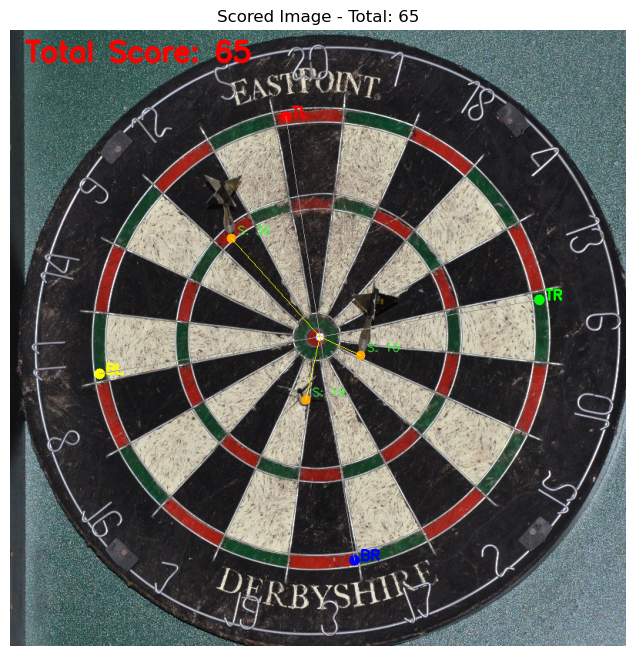


--- 显示标准坐标系可视化图像 ---


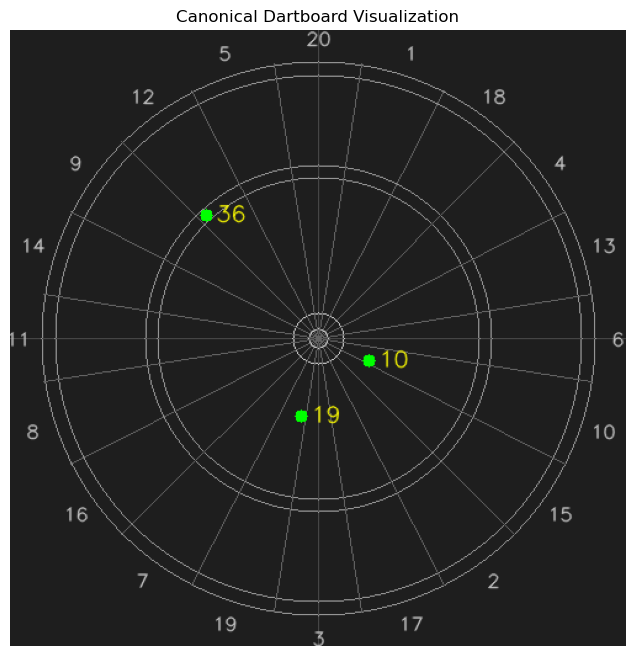


--- 最终分数总结 ---
  Dart 0 (Conf: 0.888): Score = 36, Zone = Triple 12
  Dart 1 (Conf: 0.872): Score = 10, Zone = Single 10
  Dart 2 (Conf: 0.866): Score = 19, Zone = Single 19
  本轮总分: 65 (校验和: 65)


In [17]:
if __name__ == "__main__":
    # 检查图片是否存在，如果不存在，创建一个简单的黑色图片用于测试
    if not os.path.exists(IMAGE_PATH):
        print(f"警告：测试图片 '{IMAGE_PATH}' 不存在，将创建一个黑色图片代替。")
        dummy_img = np.zeros((600, 800, 3), dtype=np.uint8)
        cv2.putText(dummy_img,"请替换为真实的图片路径",(50, 300), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.imwrite("dart_test.jpg", dummy_img)
        IMAGE_PATH = "dart_test.jpg" # 更新路径为创建的图片
        # 对于假图片，模型很可能什么也检测不到，但流程能跑通

    # 准备可视化参数
    vis_parameters = {
        'width': VIS_WIDTH,
        'height': VIS_HEIGHT,
        'scale_factor': VIS_SCALE_FACTOR
    }

    # 调用主处理流程
    keypoints, scores_details, final_total_score, scored_image, canonical_image = main_processing_pipeline(
        POSE_MODEL_PATH, DETECTION_MODEL_PATH, IMAGE_PATH,
        POSE_CONFIDENCE_THRESHOLD, DETECTION_CONFIDENCE_THRESHOLD,
        DARTBOARD_CLASS_NAME, DART_CLASS_NAME, EXPECTED_KEYPOINTS,
        TARGET_POINTS_NORMALIZED_ROTATED,
        R_NORM, SEGMENT_VALUES, SEGMENT_ANGLE,
        vis_parameters
    )

    # 检查结果并显示
    if scored_image is not None:
        print("\n--- 显示标注后的原始图像 ---")
        display_image_notebook(scored_image, f"Scored Image - Total: {final_total_score}")
    else:
        print("\n未能生成标注后的图像。")

    if canonical_image is not None:
        print("\n--- 显示标准坐标系可视化图像 ---")
        display_image_notebook(canonical_image, "Canonical Dartboard Visualization")
    else:
        print("\n未能生成标准坐标系可视化图像。")


    # 打印最终分数总结
    if final_total_score is not None and scores_details is not None:
        print("\n--- 最终分数总结 ---")
        total_check = 0
        if scores_details:
            for score_info in scores_details:
                print(f"  Dart {score_info['dart_index']} (Conf: {score_info['confidence']:.3f}): Score = {score_info['score']}, Zone = {score_info['zone']}")
                total_check += score_info['score']
            print(f"  本轮总分: {final_total_score} (校验和: {total_check})")
            if abs(final_total_score - total_check) > 1e-5: # 考虑浮点误差
                 print("警告：计算的总分与校验和不匹配！")
        else:
            print("  未检测到飞镖或未能成功计分。")
            print(f"  本轮总分: {final_total_score}") # 可能为 0
    else:
        print("\n处理或计分过程中出现错误，未能得到最终分数。")